In [5]:
import os
from glob import glob
from tqdm import tqdm
import json
from collections import defaultdict
import random
import warnings
warnings.filterwarnings(action='ignore')
import pyrootutils
pyrootutils.setup_root(os.path.curdir, indicator=".project-root", pythonpath=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn

from src.SemanticGuidedHumanMatting.model.model import HumanSegment, HumanMatting
from src.SemanticGuidedHumanMatting import utils
from extras import paths

## aihub dataset 이동 & json 편집
- 외부 ssd => 로컬 ssd

In [6]:
aihub_dir = paths.AIHUB_DATA_DIR
train_dir = '/media/shin/T7/dataset/data/train'
test_dir = '/media/shin/T7/dataset/data/test'

In [ ]:
import shutil

def move_images_(ord_dir, images_dir):
    ord_dir = ord_dir[:-4] + "_mask" + ord_dir[-4:]

    ord_fname = ord_dir.split('/')[-1]

    image_path = os.path.join(images_dir, ord_fname)

    shutil.copyfile(ord_dir, image_path)
    
    return image_path

def move_images(json_dir, images_dir):
    pathes = glob(os.path.join(json_dir, '*.json'))

    for json_path in tqdm(pathes, desc="generate masked data"):
        with open(json_path, 'r') as f:
            json_data = json.load(f)
        front_dir = json_data['input']['front']
        side_dir = json_data['input']['side']
        
        front_path = move_images_(front_dir, images_dir)
        side_path = move_images_(side_dir, images_dir)

        json_data['input']['front'] = front_path
        json_data['input']['side'] = side_path

        with open(json_path, 'w') as f:
            json.dump(json_data, f)

json_dir = os.path.join(config.AIHUB_DATA_DIR, 'train')
images_dir = os.path.join(config.AIHUB_DATA_DIR, 'images')
move_images(json_dir, images_dir)

## aihub 데이터셋 가공후 로컬 디스크에 저장

In [8]:
def userid_label(csv_path):
    try:
        ord_df = pd.read_csv(csv_path)
    except:
        ord_df = pd.read_csv(csv_path, encoding='cp949')
    df = pd.DataFrame(ord_df.values[1:, 2:])
    df.columns = ['user_id'] + list(ord_df.values[0, 3:])
    
    label = df[['키', '젖가슴둘레', '허리둘레', '엉덩이둘레', '넙다리둘레', '팔길이', '엉덩이높이', '어깨사이너비']].values[0].astype(np.float)
    user_id = df['user_id'].values[0]
    weight = df['몸무게'].values[0]
    sex = float(df['성별'].values[0] == 'M')
    return user_id, label, float(weight), sex

In [35]:
def user_images(user_id, src):
    
    image_dir_dict = {cloth_cat: {'front_dirs': [], 'side_dirs': []} for cloth_cat in config.CLOTH_CATEGORY}

    for json_path in glob(os.path.join(src, f'jsons/TL_{user_id}/json/*')):
        try:
            with open(json_path, 'r') as f:
                json_data = json.load(f)
        
            image_name = json_data['images']['identifier']
            image_dir = os.path.join(src, f'image_csv/{user_id}/Image/{image_name}')
            if json_data['camera_number'] in (3, 4) and json_data['position'] == 'A자':
                image_dir_dict[json_data['cloth']]['front_dirs'] += [image_dir]
            elif json_data['camera_number'] in (11, 12) and json_data['position'] == '차렷':
                image_dir_dict[json_data['cloth']]['side_dirs'] += [image_dir]
        except Exception as e:
            print(e, json_path)
            continue

    return image_dir_dict

### main

In [37]:
mode = "test"

src = f'/media/shin/T7/dataset/data/{mode}'


json_id = 0
if not os.path.exists(config.AIHUB_DATA_DIR):
    os.mkdir(config.AIHUB_DATA_DIR)

dest_json_dir = os.path.join(config.AIHUB_DATA_DIR, mode)
if not os.path.exists(dest_json_dir):
    os.mkdir(dest_json_dir)

for csv_path in tqdm(glob(os.path.join(src, 'image_csv/*/csv/*.csv'))):
    try:
        user_id, label, weight, sex = userid_label(csv_path)
    except Exception as e:
        print(e, csv_path)
        continue
    image_dir_dict = user_images(user_id, src)

    for cloth_cat in image_dir_dict:
        for front_dir in image_dir_dict[cloth_cat]['front_dirs']:
            for side_dir in image_dir_dict[cloth_cat]['side_dirs']:
                user_dict = {
                    "input": {
                        "front": front_dir, 
                        "side": side_dir,
                        "height": label[0], 
                        "weight": weight,
                        "sex": sex
                    }, 
                    "output": {
                        meas: label[i] for i, meas in enumerate(config.MEASUREMENTS_ORDER)
                    }
                }
                with open(os.path.join(dest_json_dir, f'{json_id}.json'), 'w') as f:
                    json.dump(user_dict, f)
                json_id += 1

100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


### segmentation model load

In [32]:
model = HumanMatting(backbone='resnet50')
model = nn.DataParallel(model).eval()
model.load_state_dict(torch.load(config.SEGMODEL_PATH, map_location=torch.device('cuda')))

<All keys matched successfully>

## segmentation을 통해 masked된 이미지를 저장

In [33]:
def preprocessing(arr):
    arr = np.fliplr(arr)
    arr = np.rot90(arr)
    return arr

In [40]:
def load_save(src, images_dir):
    arr = plt.imread(src)
    arr = preprocessing(arr)

    masked, _ = inference.single_inference(model, Image.fromarray(arr), torch.device('cuda'))

    fname = src.split('/')[-1]
    dest = os.path.join(images_dir, fname)
    plt.imsave(dest, masked, cmap='gray')
    
    return dest

def save_masked(json_dir, images_dir):
    pathes = glob(os.path.join(json_dir, '*.json'))

    for json_path in tqdm(pathes, desc="generate masked data"):
        with open(json_path, 'r') as f:
            json_data = json.load(f)
        front_dir = json_data['input']['front']
        side_dir = json_data['input']['side']
        front_dest = load_save(front_dir, images_dir)
        side_dest = load_save(side_dir, images_dir)

        json_data['input']['front'] = front_dest
        json_data['input']['side'] = side_dest

        with open(json_path, 'w') as f:
            json.dump(json_data, f)

json_dir = os.path.join(config.AIHUB_DATA_DIR, 'test')
images_dir = os.path.join(config.AIHUB_DATA_DIR, 'images')
save_masked(json_dir, images_dir)

generate masked data: 100%|██████████| 168/168 [01:27<00:00,  1.92it/s]


## segmentation 결과 확인

In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from PIL import Image
from glob import glob
import os
import json

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [4]:
model_path = "/home/shin/VScodeProjects/fittering-ML/opensrc/mediapipe/models/selfie_segmenter.tflite"
# model_path = "./models/selfie_segmenter_landscape.tflite"

BaseOptions = mp.tasks.BaseOptions
ImageSegmenter = mp.tasks.vision.ImageSegmenter
ImageSegmenterOptions = mp.tasks.vision.ImageSegmenterOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a image segmenter instance with the image mode:
options = ImageSegmenterOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.IMAGE,
    output_category_mask=True)

In [5]:
def mediapipe_inference(image_path):
    mp_image = mp.Image.create_from_file(image_path)
    with ImageSegmenter.create_from_options(options) as segmenter:
        segmented_masks = segmenter.segment(mp_image)
    mediapipe_result = ~segmented_masks.category_mask.numpy_view()
    return mediapipe_result

In [6]:
def original_path(masked_path):
    img_fname = masked_path.split('/')[-1]
    userid = img_fname.split('_')[2]
    ori_path = f"/media/shin/T7/dataset/data/train/image_csv/{userid}/Image/{img_fname}"
    return ori_path

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
/home/shin/anaconda3/envs/seg-env/lib/python3.8/site-packages/google/protobuf/message_factory.py:166: UserWarning: MessageFactory class is deprecated. Please use GetMessageClass() instead of MessageFactory.GetPrototype. MessageFactory class will be removed after 2024.
  warnings.warn('MessageFactory class is deprecated. Please use '


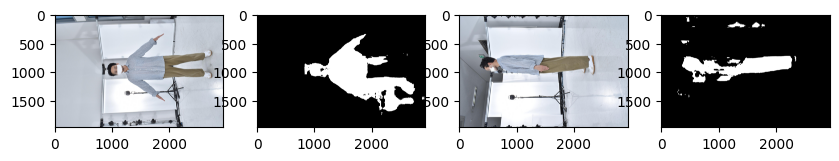

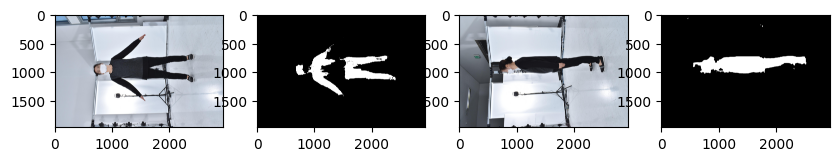

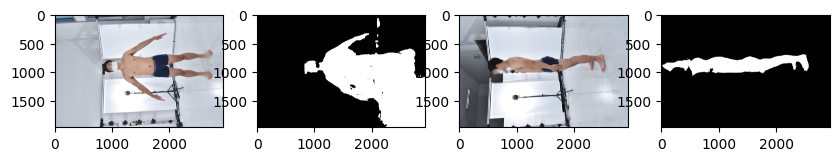

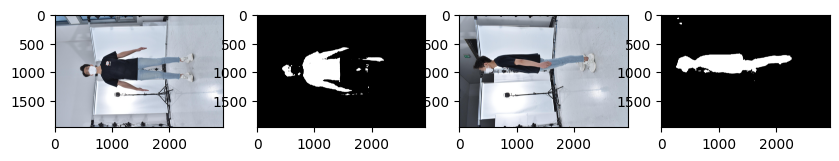

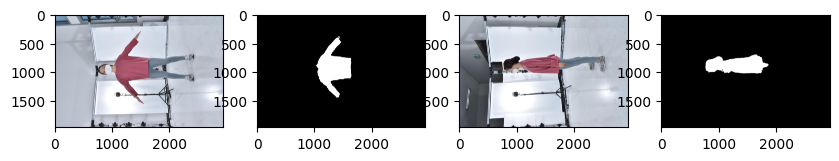

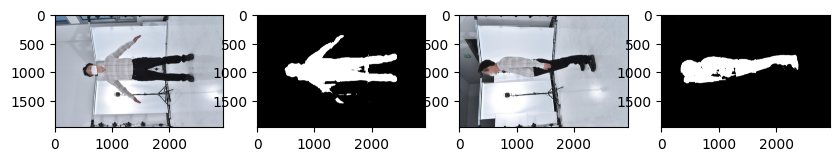

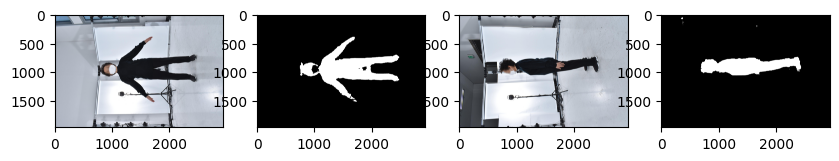

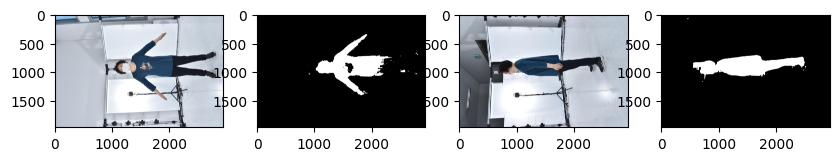

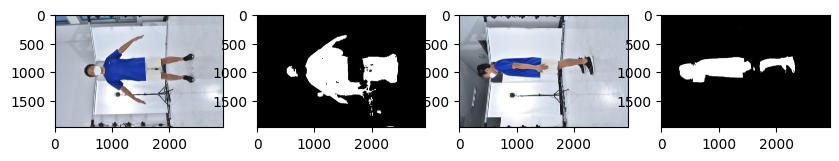

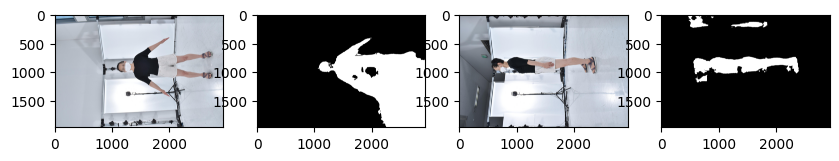

In [7]:
pathes = glob(os.path.join('/home/shin/VScodeProjects/fittering-ML/data/source/aihub/train', '*.json'))
pathes = np.random.choice(pathes, 10)
device = torch.device('cuda')

for json_path in pathes:
    with open(json_path, 'r') as f:
        json_data = json.load(f)
    front_dir = json_data['input']['front']
    side_dir = json_data['input']['side']
    front_dir = original_path(front_dir)
    side_dir = original_path(side_dir)

    front_arr = plt.imread(front_dir)
    # front_arr = preprocessing(front_arr)
    side_arr = plt.imread(side_dir)
    # side_arr = preprocessing(side_arr)


    # front_masked, _ = inference.single_inference(model, Image.fromarray(front_arr), device)
    # side_masked, _ = inference.single_inference(model, Image.fromarray(side_arr), device)

    front_masked = mediapipe_inference(front_dir)
    side_masked = mediapipe_inference(side_dir)
    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 4))
    axes[0].imshow(front_arr)
    axes[1].imshow(front_masked, cmap='gray')
    axes[2].imshow(side_arr)
    axes[3].imshow(side_masked, cmap='gray')
    plt.show()